In [1]:
!pwd
!export PYTHONPATH=$PYTHONPATH:$(pwd)/evidential-learning-pytorch

import sys
print(sys.path)
sys.path.append('/work/DRO-EDL/1d/evidential-learning-pytorch')

from tqdm import tqdm
from scipy.stats import norm

import numpy as np
from scipy.stats import norm, invgamma

import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import minimize
from scipy.integrate import dblquad

import torch

from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from edl_pytorch import NormalInvGamma, evidential_regression

import torch.optim as optim

/work/DRO-EDL/2d
['/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/opencda/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages']


In [2]:
def cart2polar(x,y):
    r = (x**2 + y**2)**(1/2)
    theta = np.arctan2(y,x)
    return r , theta

def polar2cart(r,theta):
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return x,y

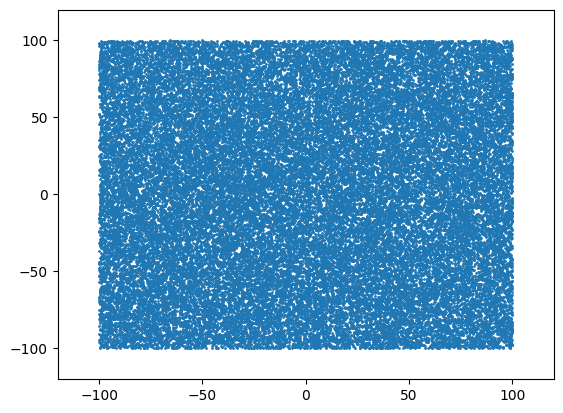

In [3]:
# create y sample
num_sample = 50000
x_range, y_range = [-100, 100], [-100, 100]
x = np.random.uniform(*x_range, num_sample)
y = np.random.uniform(*y_range, num_sample)
plt.scatter(x,y, s=1)
plt.xlim(-120, 120)
plt.ylim(-120, 120)
plt.show()

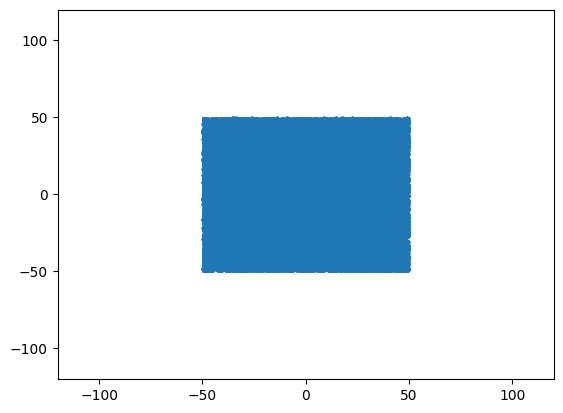

In [4]:
# create y sample
num_sample = 50000
x_range, y_range = [-50, 50], [-50, 50]
x = np.random.uniform(*x_range, num_sample)
y = np.random.uniform(*y_range, num_sample)
plt.scatter(x,y, s=1)
plt.xlim(-120, 120)
plt.ylim(-120, 120)
plt.show()

In [5]:
x = torch.tensor(x, dtype=torch.float)[:,None]
y = torch.tensor(y, dtype=torch.float)[:,None]

In [6]:

train_data = torch.concat([x, y], axis=1)
sigma = torch.normal(torch.zeros_like(train_data[:,0]), 1 * torch.ones_like(train_data[:,0])).unsqueeze(-1)
y_train = train_data + sigma
x_train = torch.tensor([cart2polar(x,y) for x,y in train_data])


# test_data = torch.concat([x, y], axis=1)
test_data = torch.concat([torch.linspace(-200, 200, 1000).unsqueeze(-1), torch.linspace(-200, 200, 1000).unsqueeze(-1)], axis=1)
y_test = test_data
x_test = torch.tensor([cart2polar(x,y) for x,y in test_data])

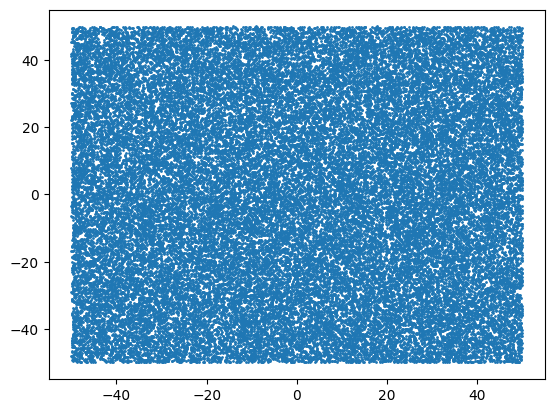

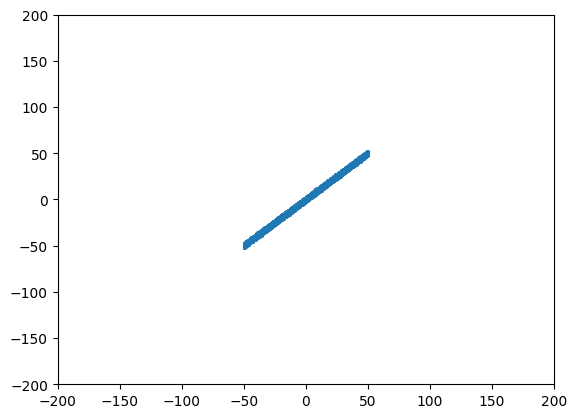

In [7]:
plt.scatter(train_data[:,0], train_data[:,1], s=1)
# plt.ylim(8,12)
plt.show()
# train_data[:5]
plt.scatter(train_data[:,0], y_train[:,0], s=1)
plt.xlim(-200, 200)
plt.ylim(-200, 200)
plt.show()

In [8]:
class EDL_model(nn.Module):
    def __init__(self):
        super(EDL_model, self).__init__()
        
        self.backbone = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
        )
        self.head = nn.Sequential(
            NormalInvGamma(64, 2),
        )
            
    def forward(self, x):
        feat = self.backbone(x)
        x_out = self.head_x(feat)
        y_out = self.head_y(feat)
        out = list()
        for x,y  in zip(x_out, y_out):
            out.append(torch.cat([x,y], dim=1))
        return tuple(out)
model = EDL_model()
model(torch.tensor(x_train[:3], dtype=torch.float))

/tmp/ipykernel_1297/4151504618.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model(torch.tensor(x_train[:3], dtype=torch.float))


(tensor([[0.4620, 0.4016],
         [0.5394, 0.4803],
         [0.6130, 0.5450]], grad_fn=<CatBackward0>),
 tensor([[1.1928, 0.8230],
         [1.3046, 0.8553],
         [1.4036, 0.8835]], grad_fn=<CatBackward0>),
 tensor([[1.7836, 1.5877],
         [1.8026, 1.5552],
         [1.8149, 1.5434]], grad_fn=<CatBackward0>),
 tensor([[0.8093, 0.7700],
         [0.8096, 0.7769],
         [0.8233, 0.7804]], grad_fn=<CatBackward0>))

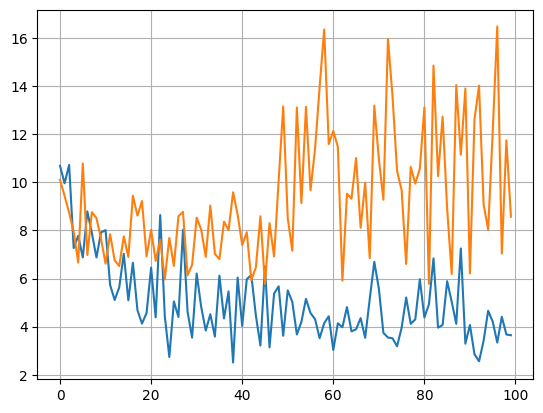

100%|█████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


In [30]:
from IPython.display import clear_output

torch.manual_seed(0)

model = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    NormalInvGamma(64, 2),
)
err = False
model = model.to('cuda:0')
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
train_loss_list = list()
val_loss_list = list()

fig, ax = plt.subplots()
for epoch in tqdm(range(100)):
    for x, y in DataLoader(TensorDataset(x_train, y_train), batch_size=100, shuffle=True):
        x, y = x.to('cuda:0'), y.to('cuda:0')
        pred = model(x)
        pred_x = [x[0].unsqueeze(-1) for x in pred]
        pred_y = [x[1].unsqueeze(-1) for x in pred]
        loss_x = evidential_regression(pred_x, y[0].unsqueeze(-1), lamb=1e-2)
        loss_y = evidential_regression(pred_y, y[1].unsqueeze(-1), lamb=1e-2)
        loss = loss_x + loss_y
        if loss.isnan():
            print("nan!")
            err = True
            break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if err:
        break
    train_loss_list.append(loss.detach().cpu())
    with torch.no_grad():
        x_test, y_test = x_test.to('cuda:0'), y_test.to('cuda:0')
        pred = model(x_test)
        loss = evidential_regression(pred, y_test, lamb=1e-2)
        val_loss_list.append(loss.detach().cpu())
    torch.save(model.state_dict(), f'uncertain_weights/{epoch}.pth')

    clear_output(wait=True)
    plt.plot(train_loss_list)
    plt.plot(val_loss_list)
    plt.grid(True)
    plt.pause(0.0001)
plt.show()


In [31]:
model = model.cpu()
x_train, x_test = x_train.cpu(), x_test.cpu()
y_train, y_test = y_train.cpu(), y_test.cpu()

import ipywidgets as widgets

def update(uncertain_ep):
    x_test = torch.tensor([cart2polar(x,y) for x,y in test_data])


    fig, ax = plt.subplots(1,2, figsize=(10, 3), dpi=200)

    # 1. Certain
    model.load_state_dict(torch.load(f'uncertain_weights/{uncertain_ep}.pth', weights_only=True))
    
    with torch.no_grad():
        pred = model(x_test)
    
    # x predict
    mu, v, alpha, beta = [x[:,0] for x in (d.squeeze() for d in pred)]
    x_test = x_test.squeeze()
    ep_var = torch.sqrt(beta / (v * (alpha - 1)))
    al_var = torch.sqrt(beta / (alpha - 1))
    
    x_test_data = [polar2cart(x,y)[0] for x,y in x_test]
    ax[0].plot(x_test_data, y_test, c="k", label="True")
    ax[0].plot(x_test_data, mu, c="tab:blue", ls="--", label="Pred")
    for std in range(4):
        ax[0].fill_between(
            x_test_data,
            (mu - std * ep_var),
            (mu + std * ep_var),
            alpha=0.2,
            facecolor="tab:blue",
            label="Unc." if std == 0 else None,
        )
    ax[0].set_ylim(-200, 200)
    ax[0].legend(loc="upper left")
    ax[0].set_title(f'x axis | epoch: {uncertain_ep}')

    # y predict
    mu, v, alpha, beta = [x[:,1] for x in (d.squeeze() for d in pred)]
    x_test = x_test.squeeze()
    ep_var = torch.sqrt(beta / (v * (alpha - 1)))
    al_var = torch.sqrt(beta / (alpha - 1))
    
    x_test_data = [polar2cart(x,y)[0] for x,y in x_test]
    ax[1].plot(x_test_data, y_test, c="k", label="True")
    ax[1].plot(x_test_data, mu, c="tab:blue", ls="--", label="Pred")
    for std in range(4):
        ax[1].fill_between(
            x_test_data,
            (mu - std * ep_var),
            (mu + std * ep_var),
            alpha=0.2,
            facecolor="tab:blue",
            label="Unc." if std == 0 else None,
        )
    ax[1].set_ylim(-100, 100)
    ax[1].legend(loc="upper left")
    ax[1].set_title(f'y axis | epoch: {uncertain_ep}')


    
    plt.show()
    
uncertain_ep = widgets.IntSlider(value=0, min=0, max=99, step=1, description='uncertain_epoch')
ui = widgets.VBox([uncertain_ep])
out = widgets.interactive_output(update, {
    'uncertain_ep': uncertain_ep, 
})

display(ui, out)

Output()

In [39]:
from scipy.stats import invgamma, norm

In [65]:
def NIG_sample(params):
    mu_0, lambda_, alpha, beta = params
    x_sigma2_dist = invgamma(alpha, scale=beta)
    sigma2 = x_sigma2_dist.rvs(1)
    x_mu_dist = norm(mu_0, np.sqrt(sigma2 / lambda_))
    mu = x_mu_dist.rvs(1)
    return np.array([mu[0], sigma2[0]])

In [78]:
model.load_state_dict(torch.load(f'uncertain_weights/{90}.pth', weights_only=True))

sample = [70, 70]

# 2D ambiguity set visualization

In [86]:

from ipywidgets import interact, FloatSlider

def plot(x, y):
    plt.figure(figsize=(8,8))
    
    print(x, y)
    sample = [x, y]
    input_data = torch.tensor(cart2polar(*sample), dtype=torch.float)[None,:]
    with torch.no_grad():
        pred = model(input_data)
    x_params = [pred[0][0,0], pred[1][0,0], pred[2][0,0], pred[3][0,0]]
    y_params = [pred[0][0,1], pred[1][0,1], pred[2][0,1], pred[3][0,1]]

    for _ in range(100):
        x_dist_params = NIG_sample(x_params)
        y_dist_params = NIG_sample(y_params)

        mean = np.array([x_dist_params[0], y_dist_params[0]])
        cov = np.array([
            [x_dist_params[1], 0],
            [0, y_dist_params[1]]
        ])


        # 공분산 행렬의 고유값과 고유벡터 계산
        eigvals, eigvecs = np.linalg.eigh(cov)

        # 1-sigma 수준에서 타원의 축 반지름 계산
        axis_lengths = np.sqrt(eigvals)

        # 타원의 각도 계산 (라디안)
        angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])

        # 타원 좌표 생성
        theta = np.linspace(0, 2 * np.pi, 100)
        ellipse = np.array([axis_lengths[0] * np.cos(theta), axis_lengths[1] * np.sin(theta)])

        # 타원의 회전 적용
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                     [np.sin(angle), np.cos(angle)]])
        rotated_ellipse = rotation_matrix @ ellipse

        # 타원을 평균 좌표로 이동
        ellipse_x, ellipse_y = rotated_ellipse[0] + mean[0], rotated_ellipse[1] + mean[1]
        plt.plot(ellipse_x, ellipse_y, color='blue', alpha=0.5)

    plt.scatter(*sample)
    plt.xlim(-100, 100)
    plt.ylim(-100, 100)
    plt.show()


interact(
        plot,
        x=FloatSlider(min=-100, max=100, step=1, value=0, description='Major Axis (a)'),
        y=FloatSlider(min=-100, max=100, step=1, value=0, description='Minor Axis (b)'),
);


interactive(children=(FloatSlider(value=0.0, description='Major Axis (a)', min=-100.0, step=1.0), FloatSlider(…

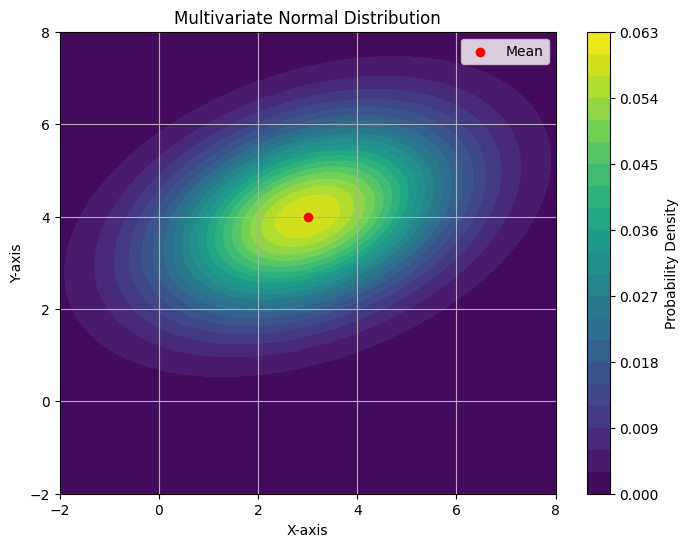

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# 평균과 공분산 설정
mean = [3, 4]
cov = [[4, 1], [1, 2]]

# 그리드 생성
x, y = np.meshgrid(np.linspace(-2, 8, 100), np.linspace(-2, 8, 100))
pos = np.dstack((x, y))

# 다변량 정규 분포 정의
rv = multivariate_normal(mean, cov)

# 분포의 확률 밀도 계산
z = rv.pdf(pos)

# 시각화
plt.figure(figsize=(8, 6))
contour = plt.contourf(x, y, z, cmap='viridis', levels=20)
plt.colorbar(contour, label="Probability Density")
plt.title("Multivariate Normal Distribution")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.scatter(mean[0], mean[1], color='red', label='Mean', zorder=10)
plt.legend()
plt.show()


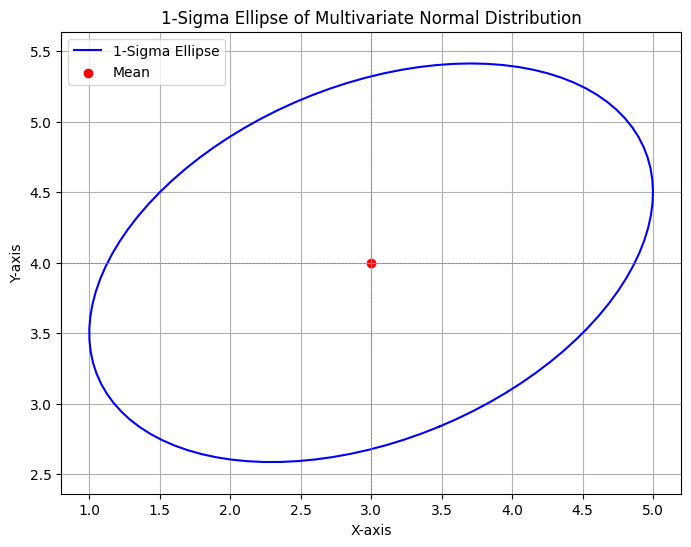

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# 평균과 공분산 설정
mean = [3, 4]
cov = [[4, 1], [1, 2]]

# 공분산 행렬의 고유값과 고유벡터 계산
eigvals, eigvecs = np.linalg.eigh(cov)

# 1-sigma 수준에서 타원의 축 반지름 계산
axis_lengths = np.sqrt(eigvals)

# 타원의 각도 계산 (라디안)
angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])

# 타원 좌표 생성
theta = np.linspace(0, 2 * np.pi, 100)
ellipse = np.array([axis_lengths[0] * np.cos(theta), axis_lengths[1] * np.sin(theta)])

# 타원의 회전 적용
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                             [np.sin(angle), np.cos(angle)]])
rotated_ellipse = rotation_matrix @ ellipse

# 타원을 평균 좌표로 이동
ellipse_x, ellipse_y = rotated_ellipse[0] + mean[0], rotated_ellipse[1] + mean[1]

# 시각화
plt.figure(figsize=(8, 6))
plt.plot(ellipse_x, ellipse_y, color='blue', label="1-Sigma Ellipse")
plt.scatter(mean[0], mean[1], color='red', label='Mean')
plt.title("1-Sigma Ellipse of Multivariate Normal Distribution")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.axhline(mean[1], color='gray', linestyle='--', linewidth=0.5)
plt.axvline(mean[0], color='gray', linestyle='--', linewidth=0.5)
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()


In [87]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import ipywidgets as widgets
from ipywidgets import interact
from scipy.stats import multivariate_normal

def plot_distribution(mean_x, var_x, mean_y, var_y, point_x, point_y):
    # 설정한 2차원 정규분포의 평균과 공분산 행렬 정의
    mean = [mean_x, mean_y]
    cov = [[var_x, 0], [0, var_y]]
    
    # 2차원 정규분포 데이터 생성
    x, y = np.mgrid[0:10:0.1, 0:10:0.1]
    pos = np.dstack((x, y))
    rv = multivariate_normal(mean, cov)
    
    # 그래프 시각화
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # 분포 그리기
    ax.contourf(x, y, rv.pdf(pos), levels=30, cmap='viridis')
    ax.scatter(point_x, point_y, c='red', label='Point', zorder=5)
    
    # 평균점과 공분산 타원 추가
    ax.scatter(mean_x, mean_y, c='white', marker='x', label='Mean', zorder=5)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues)
    ell = Ellipse(mean, width, height, angle, edgecolor='white', facecolor='none', linestyle='--', linewidth=2, zorder=5)
    ax.add_patch(ell)
    
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_title("2D Multivariate Normal Distribution")
    ax.legend()
    plt.show()

# Interactive 슬라이더와 함수 결합
interact(
    plot_distribution,
    mean_x=widgets.FloatSlider(value=4, min=3, max=5, step=0.1, description="Mean X"),
    var_x=widgets.FloatSlider(value=2, min=1, max=3, step=0.1, description="Variance X"),
    mean_y=widgets.FloatSlider(value=6, min=5, max=8, step=0.1, description="Mean Y"),
    var_y=widgets.FloatSlider(value=3, min=2, max=4, step=0.1, description="Variance Y"),
    point_x=widgets.FloatSlider(value=5, min=0, max=10, step=0.1, description="Point X"),
    point_y=widgets.FloatSlider(value=5, min=0, max=10, step=0.1, description="Point Y")
)


interactive(children=(FloatSlider(value=4.0, description='Mean X', max=5.0, min=3.0), FloatSlider(value=2.0, d…

<function __main__.plot_distribution(mean_x, var_x, mean_y, var_y, point_x, point_y)>

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import ipywidgets as widgets
from ipywidgets import interact
from scipy.stats import multivariate_normal

def plot_distribution(mean_x, var_x, mean_y, var_y, point_x, point_y):
    # 설정한 2차원 정규분포의 평균과 공분산 행렬 정의
    mean = [mean_x, mean_y]
    cov = [[var_x, 0], [0, var_y]]
    
    # 2차원 정규분포 데이터 생성
    x, y = np.mgrid[0:10:0.1, 0:10:0.1]
    pos = np.dstack((x, y))
    rv = multivariate_normal(mean, cov)
    
    # 임의의 점과의 거리 계산
    point = np.array([point_x, point_y])
    distance = np.linalg.norm(np.array(mean) - point)
    transformed_distance = max(0, 10 - distance)
    
    # 그래프 시각화
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # 첫 번째 서브플롯: 다변량 정규분포
    ax[0].contourf(x, y, rv.pdf(pos), levels=30, cmap='viridis')
    ax[0].scatter(point_x, point_y, c='red', label='Point', zorder=5)
    ax[0].scatter(mean_x, mean_y, c='white', marker='x', label='Mean', zorder=5)
    
    # 1-sigma 타원 추가
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues)
    ell = Ellipse(mean, width, height, angle, edgecolor='white', facecolor='none', linestyle='--', linewidth=2, zorder=5)
    ax[0].add_patch(ell)
    
    ax[0].set_xlim(0, 10)
    ax[0].set_ylim(0, 10)
    ax[0].set_xlabel("X-axis")
    ax[0].set_ylabel("Y-axis")
    ax[0].set_title("2D Multivariate Normal Distribution")
    ax[0].legend()
    
    # 두 번째 서브플롯: 10-d 값의 분포
    d_values = np.linspace(0, 10, 500)
    transformed_values = np.maximum(0, 10 - d_values)
    ax[1].plot(d_values, transformed_values, label="10 - d", color='blue')
    ax[1].scatter([distance], [transformed_distance], c='red', label=f"10 - {distance:.2f}", zorder=5)
    ax[1].set_xlabel("Distance (d)")
    ax[1].set_ylabel("10 - d")
    ax[1].set_title("Transformed Distance Distribution")
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

# Interactive 슬라이더와 함수 결합
interact(
    plot_distribution,
    mean_x=widgets.FloatSlider(value=4, min=3, max=5, step=0.1, description="Mean X"),
    var_x=widgets.FloatSlider(value=2, min=1, max=3, step=0.1, description="Variance X"),
    mean_y=widgets.FloatSlider(value=6, min=5, max=8, step=0.1, description="Mean Y"),
    var_y=widgets.FloatSlider(value=3, min=2, max=4, step=0.1, description="Variance Y"),
    point_x=widgets.FloatSlider(value=5, min=0, max=10, step=0.1, description="Point X"),
    point_y=widgets.FloatSlider(value=5, min=0, max=10, step=0.1, description="Point Y")
)


interactive(children=(FloatSlider(value=4.0, description='Mean X', max=5.0, min=3.0), FloatSlider(value=2.0, d…

<function __main__.plot_distribution(mean_x, var_x, mean_y, var_y, point_x, point_y)>

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import ipywidgets as widgets
from ipywidgets import interact
from scipy.stats import multivariate_normal

def plot_distribution_with_cvar(mean_x, var_x, mean_y, var_y, point_x, point_y, alpha):
    # 설정한 2차원 정규분포의 평균과 공분산 행렬 정의
    mean = [mean_x, mean_y]
    cov = [[var_x, 0], [0, var_y]]
    rv = multivariate_normal(mean, cov)
    
    # 다변량 정규분포 샘플링
    samples = rv.rvs(size=100000)
    
    # 임의의 점과 각 샘플 사이의 거리 계산
    point = np.array([point_x, point_y])
    distances = np.linalg.norm(samples - point, axis=1)
    
    # 거리 기반 확률분포 계산
    transformed_distances = 10 - distances
    hist, bin_edges = np.histogram(transformed_distances, bins=100, range=(0, 10), density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # CVaR 계산
    sorted_transformed_distances = np.sort(transformed_distances)
    var_index = int((1 - alpha) * len(sorted_transformed_distances))
    var = sorted_transformed_distances[var_index]
    cvar = np.mean(sorted_transformed_distances[var_index:])
    
    # 그래프 시각화
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # 첫 번째 서브플롯: 다변량 정규분포
    ax[0].scatter(point_x, point_y, c='red', label='Point', zorder=5)
    ax[0].scatter(mean_x, mean_y, c='blue', marker='x', label='Mean', zorder=5)
    
    # 1-sigma 타원 추가
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues)
    ell = Ellipse(mean, width, height, angle, edgecolor='blue', facecolor='none', linestyle='--', linewidth=2, zorder=5)
    ax[0].add_patch(ell)
    
    ax[0].set_xlim(0, 10)
    ax[0].set_ylim(0, 10)
    ax[0].set_xlabel("X-axis")
    ax[0].set_ylabel("Y-axis")
    ax[0].set_title("2D Multivariate Normal Distribution")
    ax[0].legend()
    
    # 두 번째 서브플롯: 거리 기반 확률분포와 CVaR
    ax[1].plot(bin_centers, hist, label="P(10 - d)", color='blue')
    ax[1].axvline(var, color='green', linestyle='--', label=f"VaR (α={alpha}) = {var:.2f}")
    ax[1].axvline(cvar, color='red', linestyle='-', label=f"CVaR = {cvar:.2f}")
    ax[1].set_xlabel("10 - d")
    ax[1].set_ylabel("Probability Density")
    ax[1].set_title("Transformed Distance Distribution (10 - d)")
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

# Interactive 슬라이더와 함수 결합
interact(
    plot_distribution_with_cvar,
    mean_x=widgets.FloatSlider(value=4, min=3, max=5, step=0.1, description="Mean X"),
    var_x=widgets.FloatSlider(value=2, min=1, max=3, step=0.1, description="Variance X"),
    mean_y=widgets.FloatSlider(value=6, min=5, max=8, step=0.1, description="Mean Y"),
    var_y=widgets.FloatSlider(value=3, min=2, max=4, step=0.1, description="Variance Y"),
    point_x=widgets.FloatSlider(value=5, min=0, max=10, step=0.1, description="Point X"),
    point_y=widgets.FloatSlider(value=5, min=0, max=10, step=0.1, description="Point Y"),
    alpha=widgets.FloatSlider(value=0.95, min=0.8, max=0.99, step=0.01, description="α")
)


interactive(children=(FloatSlider(value=4.0, description='Mean X', max=5.0, min=3.0), FloatSlider(value=2.0, d…

<function __main__.plot_distribution_with_cvar(mean_x, var_x, mean_y, var_y, point_x, point_y, alpha)>